# Generate synthetic data (1) -- compatibility check

In [1]:
import json, gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ete3 import Tree

from colaml import *
from colaml.misc import dataplot, modelplot
from myconfig import DATASET_DIR

In [2]:
import colaml
print(colaml.__version__)

0.1.dev14+g6c01617


In [3]:
from threadpoolctl import threadpool_limits
threadpool_limits(1, user_api='blas')

## Copy number frequency

- To reduce too rare orthologs, the percentage of zero-copies was set lower than in typical real data sets.
- On the other hand, to evaluate the accuracy of root frequency estimation, the percentage of two or more copies was set higher.

[0.193 0.501 0.18  0.067 0.029 0.014 0.017]


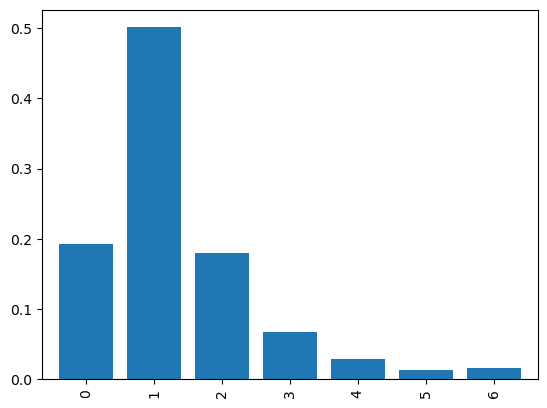

In [4]:
def discretized_lognorm_pmf(lmax, shape, loc=0.5):
    from scipy.stats import lognorm
    return np.diff(lognorm.cdf(np.append(np.arange(lmax+1), np.inf), s=shape, loc=loc))

pd.Series(discretized_lognorm_pmf(6, 0.8, 0.5)).plot.bar(width=0.8)

with np.printoptions(precision=3):
    print(discretized_lognorm_pmf(6, 0.8, 0.5))

## Generate

- $r \sim \Gamma(2, 0.10/2)$
- $s \sim \Gamma(3, 0.01/2)$
- $\pi \sim \operatorname{Dir}(\text{[see above]} * 20)$
- $\phi \sim \operatorname{Dir}(20, 20, ...)$

In [5]:
SIM01_DIR = DATASET_DIR/'01-simulation01'
conditions = pd.read_csv(SIM01_DIR/'conditions.tsv', sep='\t')

In [6]:
from colaml.__main__ import CoLaMLEncoder

In [7]:
rng = np.random.default_rng(seed=718326645216)

for cond in conditions.itertuples(index=False):
    init_model = dict(
        ncharstates = cond.lmax + 1, 
        ncategories = cond.ncat, 
        invariant_cat = False, 
        prior_kw = None, 
        init_params_method = 'skip'
    )
    distr_kw = dict(
        cpy_root_probs=discretized_lognorm_pmf(cond.lmax, 0.8, 0.5) * 20, 
        cat_root_probs=np.full(cond.ncat, 20), 
        cpy_change_rates=(2, 0.10 / 2), 
        cat_switch_rates=(3, 0.01 / 3)
    )
    mmm = MarkovModulatedTreeModel(substmodelclass=MarkovModulatedBDARD, **init_model)
    
    (SIM01_DIR.with_suffix('.tmp')/cond.conditionID).mkdir(exist_ok=True)
    for rep in range(1, 11):
        rng_bgstate = rng.bit_generator.state
        tree = Tree(f'./rphylo/{cond.conditionID}-{rep:02d}.tree', format=1)
        mmm.init_params_random(rng, distr_kw=distr_kw)
        sim = mmm.simulate(tree, cond.nOGs, rng)
        columns = [*range(cond.nOGs)]
        
        data = dict(
            tree = Tree.write(sim.tree.to_ete3(), format=3, format_root_node=True),
            OGs = pd.DataFrame.from_dict(
                sim.drop_past().to_dict(copy=False), columns=columns, orient='index'
            ).to_dict(orient='split'),
            init_model = init_model, 
            model = 'mmm', 
            params = mmm._decompress_flat_params(mmm.flat_params), 
            recon = pd.DataFrame.from_dict(
                sim.to_dict(copy=False), columns=columns, orient='index'
            ).to_dict(orient='split'),
            otherstates=[
                dict(
                    label=other.label,
                    states=pd.DataFrame.from_dict(
                        other.to_dict(copy=False), columns=columns, orient='index'
                    ).to_dict(orient='split')
                )
                for other in sim.otherstates.values()
            ],
            colattrs=[
                dict(name=colattr.label, index=columns, data=colattr.to_list(copy=False))
                for colattr in sim.colattrs.values()
            ],
            nodeattrs=[
                dict(
                    name=nodeattr.label,
                    index=[*nodeattr.to_dict(copy=False).keys()],
                    data=[*nodeattr.to_dict(copy=False).values()],
                )
                for nodeattr in sim.nodeattrs.values()
            ]
        )
        
        with gzip.open(SIM01_DIR.with_suffix('.tmp')/cond.conditionID/f'{cond.conditionID}-rep{rep:02d}.json.gz', 'wt') as file:
            json.dump(data, file, indent=2, cls=CoLaMLEncoder)

In [8]:
!find '/home/jovyan/datasets/01-simulation01' -type f -name '*.gz' -exec bash -c "zdiff {} \`echo {} | sed -e 's/01-simulation01/01-simulation01.tmp/'\`" \;

The output is exactly the same as in the previous version, which is obvious since the relevant parts have not been changed.

In [9]:
!rm -r /home/jovyan/datasets/01-simulation01.tmp